### Goal: Beat Andy and Emmanuel for ESL One Cologne fantasy league

I'd like to simulate the matchups across the tournament to determine a teams likilhood of winning the tournament. I having the most likely played out bracket, I will look at team matchups and see historically how players have performed in those matchups and also weight their performance against recent historicals for a team on a particular map. Essentially will choose the players that are predicted to perform the best (ADR-wise?) across the entire tourny.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from os import listdir
from os.path import join

import matplotlib.style as style
style.use('fivethirtyeight')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Team Level Analysis

In [2]:
team_path = '../data/master_team'
team_files = listdir(team_path)

# Import data
team_df = pd.DataFrame()
for file in team_files:
    file_df = pd.read_csv(os.path.join(team_path, file))
    team_df = team_df.append(file_df, ignore_index=True, sort=False)

# Order Columns
team_df = team_df[['date_human_utc', 'event_name', 'event_id', 'map', 'map_id',
                   'team_name', 'team_id',
                   'team_kills', 'team_assists', 'team_deaths', 'team_score']]
print('Shape before drop:', team_df.shape)

# Drop rows where there are NaN values for kills, assists, and deaths
team_df = team_df.loc[-team_df['team_kills'].isna(), :]


# Change datatypes
columns = ['event_id', 'map_id', 'team_id', 'team_kills', 'team_assists', 'team_deaths', 'team_score']
for column in columns:
    team_df[column] = team_df[column].astype(int)
    
print('Shape after drop:', team_df.shape)
team_df.tail()

Shape before drop: (132026, 11)
Shape after drop: (131974, 11)


,date_human_utc,event_name,event_id,map,map_id,team_name,team_id,team_kills,team_assists,team_deaths,team_score
132021,2019-06-30 13:00:00,Kalashnikov Cup Season 2,4463,mrg,88632,Nemiga,7969,75,16,104,13
132022,2019-06-30 12:40:00,GEXCon 2019 - NCS Major,4705,d2,88633,The Home of the Grave,10179,90,17,102,11
132023,2019-06-30 14:00:00,Good Game League 2019 Closed Qualifier,4703,trn,88634,NoChance,9722,93,17,103,13
132024,2019-06-30 14:05:00,LOOT.BET Smack My Beach Cup,4684,mrg,88635,BLUEJAYS,5347,89,13,79,16
132025,2019-06-30 13:00:00,Kalashnikov Cup Season 2,4463,nuke,88636,Nemiga,7969,107,21,87,16


I am only going to consider historicals for teams from 2018 up to present.

In [3]:
team_df = team_df.loc[team_df['date_human_utc'] >= '2018-01-01 00:00:00', :]
team_df.reset_index(drop=True, inplace=True)
print(team_df.shape)
team_df.head()

(51220, 11)


,date_human_utc,event_name,event_id,map,map_id,team_name,team_id,team_kills,team_assists,team_deaths,team_score
0,2018-01-04 07:15:00,Letou Invitational,3468,inf,59512,ViCi,7606,94,20,63,16
1,2018-01-04 08:30:00,Letou Invitational,3468,cch,59513,New4,4865,79,16,41,16
2,2018-01-04 11:00:00,Letou Invitational,3468,ovp,59514,MVP PK,7354,95,20,110,12
3,2018-01-04 17:30:00,ASUS ROG JTR Community Challenge Grand Finals ...,3488,mrg,59515,ROG friberg,8697,147,17,145,20
4,2018-01-04 18:05:00,ESEA MDL Season 26 Europe Finals,3365,mrg,59518,eXtatus,6745,107,26,110,14


In [4]:
print('Number of teams:', len(team_df['team_id'].value_counts()))
print('Number of maps:', len(team_df['map_id'].value_counts()))

Number of teams: 1889
Number of maps: 25610


### Player Level Analysis

In [65]:
path = '../data/master_players'
files = listdir(path)

# Import data
player_df = pd.DataFrame()
for file in files:
    file_df = pd.read_csv(os.path.join(path, file))
    player_df = player_df.append(file_df, ignore_index=True, sort=False)
    
# Convert unix time stamp to date time
player_df['date'] = player_df['date'] / 1000
player_df['date'] = pd.to_datetime(player_df['date'], unit ='s')
    
# Consider historical from 2018 to present
player_df = player_df.loc[player_df['date'] >= '2018-01-01 00:00:00', :]

# Keep only date
player_df['date'] = player_df['date'].dt.date

# Drop rows with NaN in KAST or ADR
player_df = player_df.loc[-player_df['KAST'].isna(), :]
player_df = player_df.loc[-player_df['ADR'].isna(), :]
player_df.reset_index(drop=True, inplace=True)
    
print(player_df.shape)
player_df.tail()

(256090, 20)


,map_id,map,date,team_id,team_name,player_id,player_name,kills,hs_kills,assists,flash_assists,deaths,KAST,kill_death_diff,ADR,first_kills_diff,rating,kills_per_round,deaths_per_round,impact
256085,79917,inf,2018-12-30,6503,CyberZen,180,Savage,12,8,5,0,17,77.3,-5,73.5,-3,0.98,0.55,0.77,0.66
256086,79918,mrg,2018-12-30,6503,CyberZen,839,tb,14,7,3,1,16,65.4,-2,65.7,-2,0.88,0.54,0.62,0.59
256087,79919,d2,2018-12-30,6503,CyberZen,839,tb,8,3,4,1,11,85.7,-3,43.3,-3,0.82,0.38,0.52,0.28
256088,79920,inf,2018-12-30,6503,CyberZen,7016,HZ,14,7,3,0,18,64.3,-4,50.9,-2,0.78,0.50,0.64,0.66
256089,79921,mrg,2018-12-30,6503,CyberZen,10168,bottle,10,5,4,1,9,77.8,1,59.7,1,1.13,0.56,0.50,0.92


To rank player performance I will consider how a particular player has played most recently and also consider how a player has matched up against a particular opponent.

Exponential Decay:
- y = a(1 - r)^x
- a = initial value (the amount before measuring growth or decay)
- r = growth or decay rate (most often represented as a percentage and expressed as a decimal)
- x = number of time intervals that have passed

#### Feature Engineering

In [66]:
# Number of days from today
current_datetime = pd.Timestamp('today').date()
player_df['days_from_today'] = (current_datetime - player_df['date']) / np.timedelta64(1, 'D')

# Exponential Decay from today
def exp_decay(days, a=1, r=0.03):
    '''
    @days: days from today
    @a: initial value
    @r: decay rate
    '''
    return a * (1 - r) ** days

player_df['decay'] = player_df['days_from_today'].apply(exp_decay)

# Normalize decay on a per player basis
player_df['normalized_decay'] = player_df['decay'] / player_df.groupby('player_id')['decay'].transform('sum')

player_df.head()

,map_id,map,date,team_id,team_name,player_id,player_name,kills,hs_kills,assists,flash_assists,deaths,KAST,kill_death_diff,ADR,first_kills_diff,rating,kills_per_round,deaths_per_round,impact,days_from_today,decay,normalized_decay
0,79922,inf,2019-01-04,8248,PACT,16847,mhL,18,9,1,0,16,63.0,2,74.5,4,1.14,0.67,0.59,1.41,181.0,0.004034,0.020712
1,79923,mrg,2019-01-04,8248,PACT,16847,mhL,19,12,4,0,17,64.0,2,79.6,-2,1.08,0.76,0.68,1.05,181.0,0.004034,0.020712
2,79924,d2,2019-01-04,7535,ROG SPUNJ,11789,Misfit,15,6,3,1,17,58.3,-2,70.1,0,0.94,0.62,0.71,0.99,181.0,0.004034,0.324556
3,79925,mrg,2019-01-04,9791,ROG pronax,17082,Ex6poN,21,9,1,0,19,65.4,2,71.0,0,1.09,0.81,0.73,1.30,181.0,0.004034,0.244233
4,79926,cch,2019-01-04,8695,ROG nooky,18457,s1las,20,11,5,0,20,79.2,0,91.4,1,1.17,0.83,0.83,1.10,181.0,0.004034,0.162479


In [67]:
# Aggregation on features with exponential decay to get current state of player
def player_features_normalized(stuff):
    new_df = pd.DataFrame()
    new_df['map_id'] = stuff['map_id']
    new_df['map'] = stuff['map']
    new_df['team_id'] = stuff['team_id']
    new_df['team_name'] = stuff['team_name']
    new_df['player_id'] = stuff['player_id']
    new_df['player_name'] = stuff['player_name']
    
    
    # Normalize features of interest
    columns = ['kills', 'assists', 'deaths', 'ADR', 'rating']
    for column in columns:
        new_df[column] = stuff[column] * stuff['normalized_decay']
    
    return new_df

player_norm_df = player_features_normalized(player_df)
player_norm_df.head()

,map_id,map,team_id,team_name,player_id,player_name,kills,assists,deaths,ADR,rating
0,79922,inf,8248,PACT,16847,mhL,0.372815,0.020712,0.331391,1.543040,0.023612
1,79923,mrg,8248,PACT,16847,mhL,0.393527,0.082848,0.352103,1.648671,0.022369
2,79924,d2,7535,ROG SPUNJ,11789,Misfit,4.868334,0.973667,5.517446,22.751350,0.305082
3,79925,mrg,9791,ROG pronax,17082,Ex6poN,5.128893,0.244233,4.640427,17.340542,0.266214
4,79926,cch,8695,ROG nooky,18457,s1las,3.249581,0.812395,3.249581,14.850586,0.190101


So from these normalized features, I would like to create a custom player score to rank the best players.

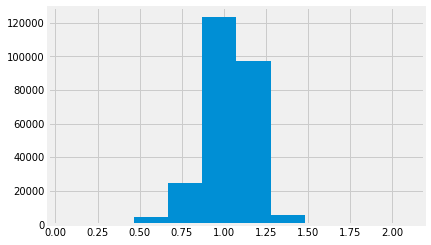

In [68]:
# Create 'true' features counts (sum up a feature)
player_norm_df['true_kills'] = player_norm_df.groupby('player_id')['kills'].transform('sum')
player_norm_df['true_assists'] = player_norm_df.groupby('player_id')['assists'].transform('sum')
player_norm_df['true_deaths'] = player_norm_df.groupby('player_id')['deaths'].transform('sum')
player_norm_df['true_ADR'] = player_norm_df.groupby('player_id')['ADR'].transform('sum')
player_norm_df['true_rating'] = player_norm_df.groupby('player_id')['rating'].transform('sum')
player_norm_df['true_rating'].hist()
plt.show()

In [72]:
# Collect only the player and their 'true' features
true_player_df = player_norm_df.drop(columns=['map_id', 'map', 'kills', 'assists', 'deaths', 'ADR', 'rating']).drop_duplicates()
print(true_player_df.shape)
true_player_df.head()

(13751, 9)


,team_id,team_name,player_id,player_name,true_kills,true_assists,true_deaths,true_ADR,true_rating
0,8248,PACT,16847,mhL,10.382967,2.301226,20.153995,50.379149,0.578057
2,7535,ROG SPUNJ,11789,Misfit,13.635393,1.994288,16.666406,63.325690,0.891901
3,9791,ROG pronax,17082,Ex6poN,17.221979,3.268116,17.239530,70.496142,1.019378
4,8695,ROG nooky,18457,s1las,15.812395,5.000000,17.654941,68.485427,1.039347
5,7538,ROG fl0m,8503,fl0m,16.133416,4.517028,17.655834,70.443003,0.969120


### ESL ONE COLOGNE - RANKING PLAYERS

So just as a review, we are looking at players weighted average kills, assists, deaths, and ADR from the past year. This was determined by exponentially decaying on their performanes. Essentially giving more weight to recent games than older games. From these features, I hope to be able to rank players reasonably well and also optimize against the fantasy leagues constraints (max: 1,000,000 USD team composition, player values [ex: 'Stewie2K' = 202,000 USD])

In [73]:
team_names = ['Liquid', 'Astralis', 'ENCE', 'Vitality', 'NRG', 'FaZe', 'FURIA', 'MIBR',
              'fnatic', 'mousesports', 'Natus Vincere', 'NiP', 'Renegades', 'Heroic', 'BIG', 'MVP PK']

esl_one_players = true_player_df.loc[true_player_df['team_name'].isin(team_names), :]
print(esl_one_players.shape)
esl_one_players.head()

(146, 9)


,team_id,team_name,player_id,player_name,true_kills,true_assists,true_deaths,true_ADR,true_rating
48,9565,Vitality,7322,apEX,18.438981,5.500822,17.422862,78.240105,1.112894
56,9565,Vitality,7168,NBK-,18.106396,4.647025,17.895484,78.258709,1.105812
233,9565,Vitality,11893,ZywOo,21.575891,5.074937,15.552060,84.452571,1.332945
235,4494,mousesports,2730,chrisJ,18.907124,3.905601,15.781652,80.437155,1.202490
241,4869,ENCE,4076,Aerial,18.083265,4.354464,17.496556,77.009155,1.139597


In [74]:
# Rank by ADR
esl_one_players.sort_values(['true_ADR'], ascending=False).head(25)

,team_id,team_name,player_id,player_name,true_kills,true_assists,true_deaths,true_ADR,true_rating
4599,6667,FaZe,8771,USTILO,20.160830,3.122224,11.014763,96.231295,1.463945
77601,6211,Renegades,8771,USTILO,20.160830,3.122224,11.014763,96.231295,1.463945
98975,4494,mousesports,7998,s1mple,25.272787,3.823352,15.419036,90.582392,1.424054
884,4608,Natus Vincere,7998,s1mple,25.272787,3.823352,15.419036,90.582392,1.424054
974,4608,Natus Vincere,8918,electronic,20.999572,4.994955,16.269370,88.061603,1.286625
76771,8297,FURIA,2496,bld,21.085074,4.538714,18.387711,88.058121,1.255555
325,5973,Liquid,8738,EliGE,21.409767,4.786286,17.421776,87.027727,1.268044
353,6665,Astralis,7592,device,20.607165,4.142795,15.752855,86.580532,1.291687
388,8297,FURIA,12553,yuurih,19.820224,4.633840,15.954030,85.448850,1.224243
765,7532,BIG,7938,XANTARES,20.594442,4.472389,18.894475,84.704111,1.150669


In [75]:
esl_one_players.sort_values(['true_rating'], ascending=False).head(25)

,team_id,team_name,player_id,player_name,true_kills,true_assists,true_deaths,true_ADR,true_rating
4599,6667,FaZe,8771,USTILO,20.160830,3.122224,11.014763,96.231295,1.463945
77601,6211,Renegades,8771,USTILO,20.160830,3.122224,11.014763,96.231295,1.463945
884,4608,Natus Vincere,7998,s1mple,25.272787,3.823352,15.419036,90.582392,1.424054
98975,4494,mousesports,7998,s1mple,25.272787,3.823352,15.419036,90.582392,1.424054
446,7354,MVP PK,11188,xeta,19.239231,6.293164,13.904745,84.149298,1.351380
233,9565,Vitality,11893,ZywOo,21.575891,5.074937,15.552060,84.452571,1.332945
353,6665,Astralis,7592,device,20.607165,4.142795,15.752855,86.580532,1.291687
974,4608,Natus Vincere,8918,electronic,20.999572,4.994955,16.269370,88.061603,1.286625
325,5973,Liquid,8738,EliGE,21.409767,4.786286,17.421776,87.027727,1.268044
375,7354,MVP PK,9172,XigN,19.842755,4.599206,15.305497,80.407985,1.266159


I have chosen my team by looking at players who on HLTV have aggregate ADR that are less than that of my 'true_ADR' feature. My team given this approach:
- yuurih (FURIA)
- VINI (FURIA)
- XANTARES (BIG)
- blameF (heroic)
- device (Astralis).

### Considerations only data where teams have played each other

In [76]:
path = '../data/master_players'
files = listdir(path)

# Import data
player_df = pd.DataFrame()
for file in files:
    file_df = pd.read_csv(os.path.join(path, file))
    player_df = player_df.append(file_df, ignore_index=True, sort=False)
    
# Convert unix time stamp to date time
player_df['date'] = player_df['date'] / 1000
player_df['date'] = pd.to_datetime(player_df['date'], unit ='s')
    
# Consider historical from 2018 to present
player_df = player_df.loc[player_df['date'] >= '2018-01-01 00:00:00', :]

# Keep only date
player_df['date'] = player_df['date'].dt.date

# Drop rows with NaN in KAST or ADR
player_df = player_df.loc[-player_df['KAST'].isna(), :]
player_df = player_df.loc[-player_df['ADR'].isna(), :]
player_df.reset_index(drop=True, inplace=True)
    
print(player_df.shape)
player_df.tail()

(256090, 20)


,map_id,map,date,team_id,team_name,player_id,player_name,kills,hs_kills,assists,flash_assists,deaths,KAST,kill_death_diff,ADR,first_kills_diff,rating,kills_per_round,deaths_per_round,impact
256085,79917,inf,2018-12-30,6503,CyberZen,180,Savage,12,8,5,0,17,77.3,-5,73.5,-3,0.98,0.55,0.77,0.66
256086,79918,mrg,2018-12-30,6503,CyberZen,839,tb,14,7,3,1,16,65.4,-2,65.7,-2,0.88,0.54,0.62,0.59
256087,79919,d2,2018-12-30,6503,CyberZen,839,tb,8,3,4,1,11,85.7,-3,43.3,-3,0.82,0.38,0.52,0.28
256088,79920,inf,2018-12-30,6503,CyberZen,7016,HZ,14,7,3,0,18,64.3,-4,50.9,-2,0.78,0.50,0.64,0.66
256089,79921,mrg,2018-12-30,6503,CyberZen,10168,bottle,10,5,4,1,9,77.8,1,59.7,1,1.13,0.56,0.50,0.92


In [77]:
# Subset dataframe by maps where only the teams in the tournament have played each other
team_names = ['Liquid', 'Astralis', 'ENCE', 'Vitality', 'NRG', 'FaZe', 'FURIA', 'MIBR',
              'fnatic', 'mousesports', 'Natus Vincere', 'NiP', 'Renegades', 'Heroic', 'BIG', 'MVP PK']

# Only data from the teams of interest
player_df = player_df.loc[player_df['team_name'].isin(team_names),:]

# Find map_ids that are shared between teams
shared_ids = []
all_ids = []
for team in team_names:
    team_df = player_df.loc[player_df['team_name'] == team, :]
    map_ids = list(team_df['map_id'].unique())

    # Check if map_id has already been collected
    for map_id in map_ids:
        if map_id in all_ids:
            shared_ids.append(map_id)
            
    all_ids = all_ids + list(map_ids)
    
print('Number of matches between all teams:', len(shared_ids))

# Collect only matches between teams in the tourny
player_df = player_df.loc[player_df['map_id'].isin(shared_ids),:]
player_df.head()

Number of matches between all teams: 994


,map_id,map,date,team_id,team_name,player_id,player_name,kills,hs_kills,assists,flash_assists,deaths,KAST,kill_death_diff,ADR,first_kills_diff,rating,kills_per_round,deaths_per_round,impact
342,80308,cch,2019-01-20,5973,Liquid,8738,EliGE,29,14,7,0,10,90.9,19,133.4,1,2.07,1.32,0.45,2.20
346,80313,mrg,2019-01-20,5973,Liquid,8520,NAF,30,10,3,2,22,72.2,8,89.2,0,1.24,0.83,0.61,1.15
349,80317,d2,2019-01-20,5973,Liquid,8738,EliGE,28,13,6,2,14,84.0,14,108.7,3,1.79,1.12,0.56,2.06
355,80323,inf,2019-01-21,5973,Liquid,8520,NAF,15,8,4,1,17,90.0,-2,85.4,2,1.07,0.75,0.85,0.71
356,80324,d2,2019-01-21,5973,Liquid,8797,Stewie2K,27,8,3,0,16,74.1,11,111.2,3,1.55,1.00,0.59,1.51


In [78]:
# Number of days from today
current_datetime = pd.Timestamp('today').date()
player_df['days_from_today'] = (current_datetime - player_df['date']) / np.timedelta64(1, 'D')

# Exponential Decay from today
def exp_decay(days, a=1, r=0.03):
    '''
    @days: days from today
    @a: initial value
    @r: decay rate
    '''
    return a * (1 - r) ** days

player_df['decay'] = player_df['days_from_today'].apply(exp_decay)

# Normalize decay on a per player basis
player_df['normalized_decay'] = player_df['decay'] / player_df.groupby('player_id')['decay'].transform('sum')

player_df.head()

,map_id,map,date,team_id,team_name,player_id,player_name,kills,hs_kills,assists,flash_assists,deaths,KAST,kill_death_diff,ADR,first_kills_diff,rating,kills_per_round,deaths_per_round,impact,days_from_today,decay,normalized_decay
342,80308,cch,2019-01-20,5973,Liquid,8738,EliGE,29,14,7,0,10,90.9,19,133.4,1,2.07,1.32,0.45,2.20,165.0,0.006567,0.000432
346,80313,mrg,2019-01-20,5973,Liquid,8520,NAF,30,10,3,2,22,72.2,8,89.2,0,1.24,0.83,0.61,1.15,165.0,0.006567,0.000432
349,80317,d2,2019-01-20,5973,Liquid,8738,EliGE,28,13,6,2,14,84.0,14,108.7,3,1.79,1.12,0.56,2.06,165.0,0.006567,0.000432
355,80323,inf,2019-01-21,5973,Liquid,8520,NAF,15,8,4,1,17,90.0,-2,85.4,2,1.07,0.75,0.85,0.71,164.0,0.006770,0.000446
356,80324,d2,2019-01-21,5973,Liquid,8797,Stewie2K,27,8,3,0,16,74.1,11,111.2,3,1.55,1.00,0.59,1.51,164.0,0.006770,0.000446


In [79]:
# Aggregation on features with exponential decay to get current state of player
def player_features_normalized(stuff):
    new_df = pd.DataFrame()
    new_df['map_id'] = stuff['map_id']
    new_df['map'] = stuff['map']
    new_df['team_id'] = stuff['team_id']
    new_df['team_name'] = stuff['team_name']
    new_df['player_id'] = stuff['player_id']
    new_df['player_name'] = stuff['player_name']
    
    
    # Normalize features of interest
    columns = ['kills', 'assists', 'deaths', 'ADR', 'rating']
    for column in columns:
        new_df[column] = stuff[column] * stuff['normalized_decay']
    
    return new_df

player_norm_df = player_features_normalized(player_df)
player_norm_df.head()

,map_id,map,team_id,team_name,player_id,player_name,kills,assists,deaths,ADR,rating
342,80308,cch,5973,Liquid,8738,EliGE,0.012541,0.003027,0.004324,0.057688,0.000895
346,80313,mrg,5973,Liquid,8520,NAF,0.012973,0.001297,0.009514,0.038574,0.000536
349,80317,d2,5973,Liquid,8738,EliGE,0.012108,0.002595,0.006054,0.047007,0.000774
355,80323,inf,5973,Liquid,8520,NAF,0.006687,0.001783,0.007579,0.038073,0.000477
356,80324,d2,5973,Liquid,8797,Stewie2K,0.012044,0.001338,0.007137,0.049602,0.000691


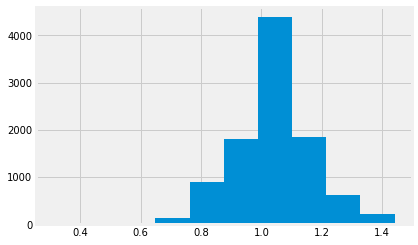

In [80]:
# Create 'true' features counts (sum up a feature)
player_norm_df['true_kills'] = player_norm_df.groupby('player_id')['kills'].transform('sum')
player_norm_df['true_assists'] = player_norm_df.groupby('player_id')['assists'].transform('sum')
player_norm_df['true_deaths'] = player_norm_df.groupby('player_id')['deaths'].transform('sum')
player_norm_df['true_ADR'] = player_norm_df.groupby('player_id')['ADR'].transform('sum')
player_norm_df['true_rating'] = player_norm_df.groupby('player_id')['rating'].transform('sum')
player_norm_df['true_rating'].hist()
plt.show()

In [81]:
# Collect only the player and their 'true' features
true_player_df = player_norm_df.drop(columns=['map_id', 'map', 'kills', 'assists', 'deaths', 'ADR', 'rating']).drop_duplicates()
print(true_player_df.shape)
true_player_df.head()

(129, 9)


,team_id,team_name,player_id,player_name,true_kills,true_assists,true_deaths,true_ADR,true_rating
342,5973,Liquid,8738,EliGE,21.989563,4.301092,17.507414,86.781680,1.263348
346,5973,Liquid,8520,NAF,17.866254,5.978353,17.009081,78.820851,1.124865
356,5973,Liquid,8797,Stewie2K,17.704708,4.519339,17.624957,72.691464,1.065740
486,6673,NRG,10671,Ethan,18.592145,5.722450,18.563796,80.251306,1.107792
488,6673,NRG,9136,Brehze,20.858208,3.616367,18.166247,80.066839,1.148113


In [82]:
# Rank by ADR
true_player_df.sort_values(['true_ADR'], ascending=False).reset_index(drop=True)

,team_id,team_name,player_id,player_name,true_kills,true_assists,true_deaths,true_ADR,true_rating
0,9565,Vitality,11893,ZywOo,23.868804,6.002576,15.906888,92.716211,1.440952
1,4608,Natus Vincere,7998,s1mple,22.592957,3.707842,14.834001,88.851319,1.379600
2,6665,Astralis,7592,device,21.026647,3.993658,16.249338,87.648427,1.290623
3,5973,Liquid,8738,EliGE,21.989563,4.301092,17.507414,86.781680,1.263348
4,4608,Natus Vincere,8918,electronic,19.008989,4.782219,15.286315,84.627240,1.244870
5,7532,BIG,7938,XANTARES,20.947599,3.897447,20.108596,84.506845,1.114679
6,4869,ENCE,11916,sergej,21.039834,3.967165,17.980076,83.732345,1.171543
7,4494,mousesports,8574,woxic,21.214666,5.088696,16.136656,82.622127,1.221218
8,4494,mousesports,2730,chrisJ,20.505434,4.065326,17.569441,81.612372,1.184797
9,7175,Heroic,15165,blameF,18.087760,5.226400,17.088954,81.212786,1.133838


In [83]:
# Rank by rating
true_player_df.sort_values(['true_rating'], ascending=False).reset_index(drop=True)

,team_id,team_name,player_id,player_name,true_kills,true_assists,true_deaths,true_ADR,true_rating
0,9565,Vitality,11893,ZywOo,23.868804,6.002576,15.906888,92.716211,1.440952
1,4608,Natus Vincere,7998,s1mple,22.592957,3.707842,14.834001,88.851319,1.379600
2,6665,Astralis,7592,device,21.026647,3.993658,16.249338,87.648427,1.290623
3,5973,Liquid,8738,EliGE,21.989563,4.301092,17.507414,86.781680,1.263348
4,4608,Natus Vincere,8918,electronic,19.008989,4.782219,15.286315,84.627240,1.244870
5,4494,mousesports,8574,woxic,21.214666,5.088696,16.136656,82.622127,1.221218
6,6665,Astralis,9032,Magisk,18.297623,4.624208,15.659036,80.450380,1.188858
7,4494,mousesports,2730,chrisJ,20.505434,4.065326,17.569441,81.612372,1.184797
8,4869,ENCE,11916,sergej,21.039834,3.967165,17.980076,83.732345,1.171543
9,4494,mousesports,11816,ropz,18.621733,3.984199,14.960267,73.994341,1.163840


### ESL ONE COLOGNE Bracket

<div align="center"><img src="../images/ESL One Cologne-Group A.png" style="width:500px;height:300px"> <img src="../images/ESL One Cologne-Group B.png" style="width:500px;height:300px"></div>

<img src="../images/ESL One Cologne-Teams.png" class="center" style="width:600px;height:600px">

Top teams from each upper bracket advances to semi-finals. The losers of the upper bracket finals play in the quarterfinals. Top teams from each lower bracket advances to quarterfinals. Teams that lose in the first round player teams from the same side of their bracket in the lower bracket. Teams in the upper bracket that lose in the second round play on the opposite side of the lower bracket. All teams starting on a particular upper bracket will only play teams of the bracket until the playoffs (quarters/semis).

## Post Analysis

Fantasy system uses an average of a players pts when that player does not play during a particular round. This means that if your player bows out early, whatever their average pts was across the rounds that they played, gets added to your total score on each of the subsequent rounds. If one of your players advances and does not have to play a round (advances to the finals of the upper bracket and makes it directly to the semis), they also carry their average across those non-played rounds. **All in all, this means that you want to choose players that will make the semi's directly because you are more likely to be guaranteed points with less variation.**

I'll simulate the tournament next time to get the most likely outcomes for the tournament and prioritize players that are on teams that are likely to make the upper bracket finals and/or the semis. I will also take the final ratings of each player from the tourny to create a dataset to train on the final ratings given pre-match aggregate features.

I need to make sure to version my data.